# Loading the necessary libraries

In [1]:
import numpy as np
import os
import glob
import tensorflow as tf
import argparse
import random
import sklearn.metrics
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm

import ecdl

import csv
import io
import json

import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Loading a trained model

In [3]:
class myargs():
    def __init__(self):
        self.exp_id = 'efficientnetb1_round3'
        self.test_data = 'first'
        self.load_type = 'weight'
   

args = myargs()


base_exp_path = '../experiments'
exp_path = os.path.join(base_exp_path, args.exp_id)
args_path = os.path.join(exp_path, 'hyperparameters.json')
with open(args_path) as json_file:
    data = json.load(json_file)

model = tf.keras.models.load_model(exp_path)

if args.load_type == 'weight':
    best_metric = 0.0
    chosen_index = 0
    all_weights = glob.glob(os.path.join(exp_path,'*.hdf5'))
    metric_list = [float(weight_file.split('-')[-1].split('.hdf5')[0]) for weight_file in all_weights]    
    for index,metric_value in enumerate(metric_list):
        if best_metric < metric_value:
            best_metric = metric_value
            chosen_index = index
    model.load_weights(all_weights[chosen_index])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(
        num_thresholds=200, curve='ROC', summation_method='interpolation', name=None,
        dtype=None, thresholds=None, multi_label=False, label_weights=None)
        ])    

# Load the dataset

In [4]:
base_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Code to evaluate the performance

In [5]:
def evaluate_model(test_dir):
    test_data_gen = base_image_generator.flow_from_directory(batch_size=10,
                                                            directory=test_dir,
                                                            shuffle=False,                                                        
                                                            target_size=(data['image_dims'], data['image_dims']),
                                                            class_mode='categorical',
                                                            )


    results = model.evaluate(test_data_gen)
    # print(results)
    return results

In [6]:
test_dir = '/workspaces/ecdl/elbow_data/Clean_Data/ActualTestSet'
results = evaluate_model(test_dir)
print(results)

Found 112 images belonging to 2 classes.
12/12 [==============================] - 1s 78ms/step - loss: 0.8827 - accuracy: 0.8036 - auc: 0.8724
[0.8826779723167419, 0.8035714030265808, 0.8724091053009033]


# Plotting the AUROC

In [7]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
#     plt.xlim([-0.5,20])
#     plt.ylim([80,100.5])
#     plt.ylim([0,1])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

Found 112 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
10/10 [==============================] - 2s 161ms/step


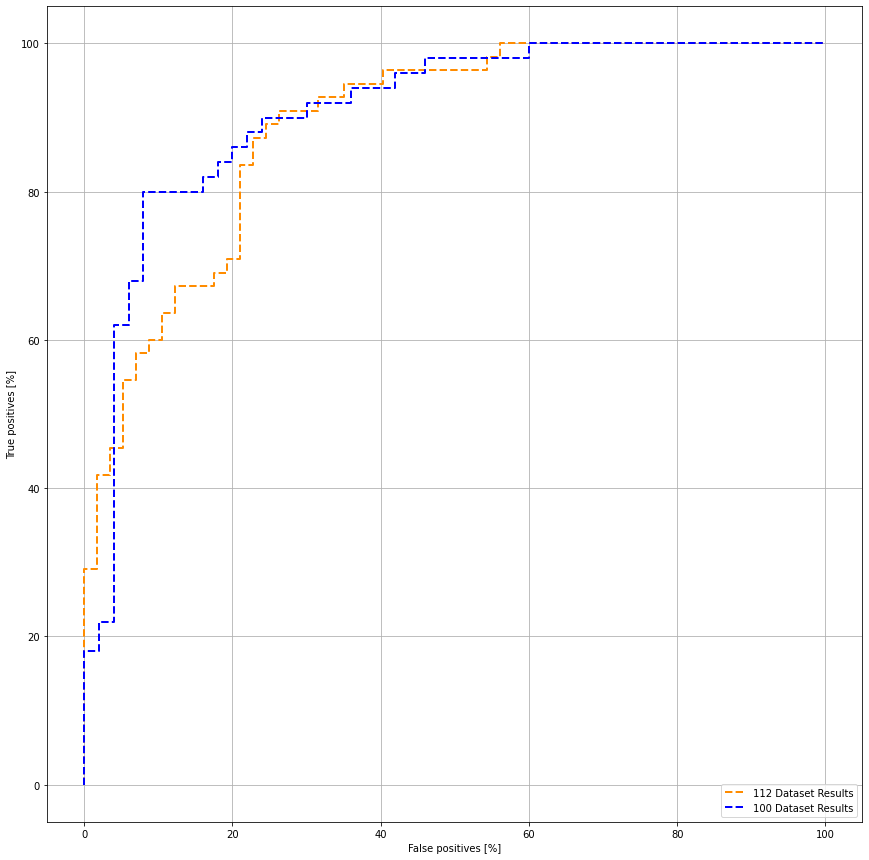

In [8]:
test_112_data_gen = base_image_generator.flow_from_directory(batch_size=10,
                                                            directory='/workspaces/ecdl/elbow_data/Clean_Data/ActualTestSet',
                                                            shuffle=False,                                                        
                                                            target_size=(data['image_dims'], data['image_dims']),
                                                            class_mode='categorical',
                                                            )

test_100_data_gen = base_image_generator.flow_from_directory(batch_size=10,
                                                            directory='/workspaces/ecdl/elbow_data/Clean_Data/SecondTestSet',
                                                            shuffle=False,                                                        
                                                            target_size=(data['image_dims'], data['image_dims']),
                                                            class_mode='categorical',
                                                            )

preds_112 = model.predict(test_112_data_gen, verbose=1)
preds_100 = model.predict(test_100_data_gen, verbose=1)

plt.figure(figsize=[15,15])
plot_roc("112 Dataset Results", test_112_data_gen.classes, preds_112[:,1], color='darkorange',linestyle='--')
plot_roc("100 Dataset Results", test_100_data_gen.classes, preds_100[:,1], color='blue',linestyle='--')
plt.legend(loc='lower right')

# Load a heatmap

In [9]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 120, 120, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 120, 120, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 120, 120, 32) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

block4a_se_expand (Conv2D)      (None, 1, 1, 240)    2640        block4a_se_reduce[0][0]          
__________________________________________________________________________________________________
block4a_se_excite (Multiply)    (None, 15, 15, 240)  0           block4a_activation[0][0]         
                                                                 block4a_se_expand[0][0]          
__________________________________________________________________________________________________
block4a_project_conv (Conv2D)   (None, 15, 15, 80)   19200       block4a_se_excite[0][0]          
__________________________________________________________________________________________________
block4a_project_bn (BatchNormal (None, 15, 15, 80)   320         block4a_project_conv[0][0]       
__________________________________________________________________________________________________
block4b_expand_conv (Conv2D)    (None, 15, 15, 480)  38400       block4a_project_bn[0][0]         
__________

# Load the last convolutional (2D) layer from the trained model

Text(0.5, 0, 'Score: [[0.9978278  0.00217218]] \nAnswer: elbow_fracture_1.jpg\nPrediction: Abnormal')

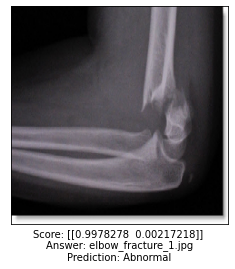

In [10]:
def produce_model_inputs(img_path, data_json):
    # Read the image and resize it
    #img = image.load_img(img_path, target_size=(height, width))
    img = image.load_img(img_path, target_size=(data_json['image_dims'], data_json['image_dims']))
    # Convert it to a Numpy array with target shape.
    image_array = image.img_to_array(img)
    normalised_image = image_array/255.

    # model_input has shape [1, 256, 256, 3]
    model_input = tf.expand_dims(normalised_image,axis=0)
    return model_input


def predict_image(model_input, model):    
    prediction = model(model_input)    

    if tf.argmax(prediction,axis=-1)[0] == 0:
        result = 'Abnormal'
    elif tf.argmax(prediction,axis=-1)[0] == 1:
        result = 'Normal'

    return prediction, result

# sample_image_path = 'elbow_data/SABINE 114 size test set/001_Normal011.jpg'
# sample_image_path = 'elbow_data/SABINE 114 size test set/002_Abnormal001.jpg'
# sample_image_path = 'elbow_data/SABINE 114 size test set/003_Abnormal009.jpg'
# sample_image_path = 'sample_images/elbow_broken.jpeg'
# sample_image_path = 'sample_images/elbow_fracture_1.jpg'
sample_image_path = '/workspaces/ecdl/sample_images/elbow_fracture_1.jpg'

model_input = produce_model_inputs(sample_image_path, data)
prediction, result = predict_image(model_input,model)
plt.imshow(model_input[0])
plt.xticks([])
plt.yticks([])
plt.xlabel(f'Score: {prediction} \nAnswer: {os.path.basename(sample_image_path)}\nPrediction: {result}')

# Visualise the heatmap

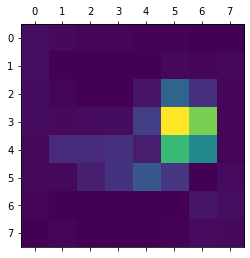

In [11]:
def make_gradcam_heatmap(
    img_array,
    model,
    activation_layer,
):
    
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(activation_layer)
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(img_array)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature lbow_data/SABINE 114 size test set/004_Normal022.jpgap
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

img_array = produce_model_inputs(sample_image_path, data)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    activation_layer='top_activation',
)


# Display heatmap
plt.matshow(heatmap)

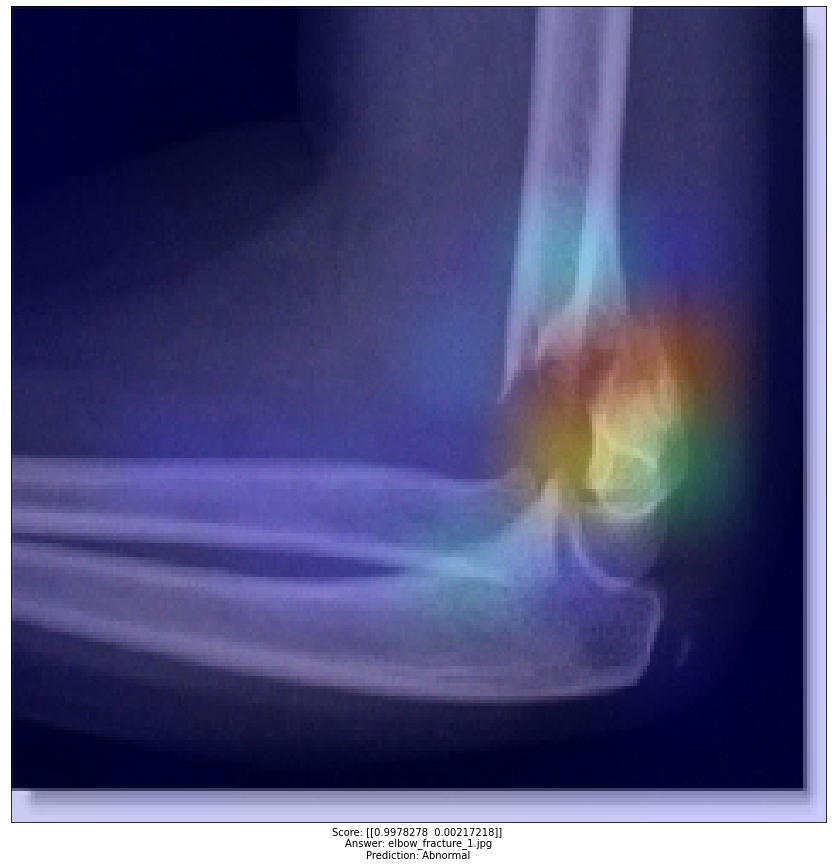

In [12]:
# We load the original image
img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(data['image_dims'],data['image_dims']))
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
brightened_heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[brightened_heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

model_input = produce_model_inputs(sample_image_path, data)
prediction, result = predict_image(model_input,model)

plt.figure(figsize=[15,15])
plt.imshow(superimposed_img)
plt.xticks([])
plt.yticks([])
plt.xlabel(f'Score: {prediction} \nAnswer: {os.path.basename(sample_image_path)}\nPrediction: {result}');

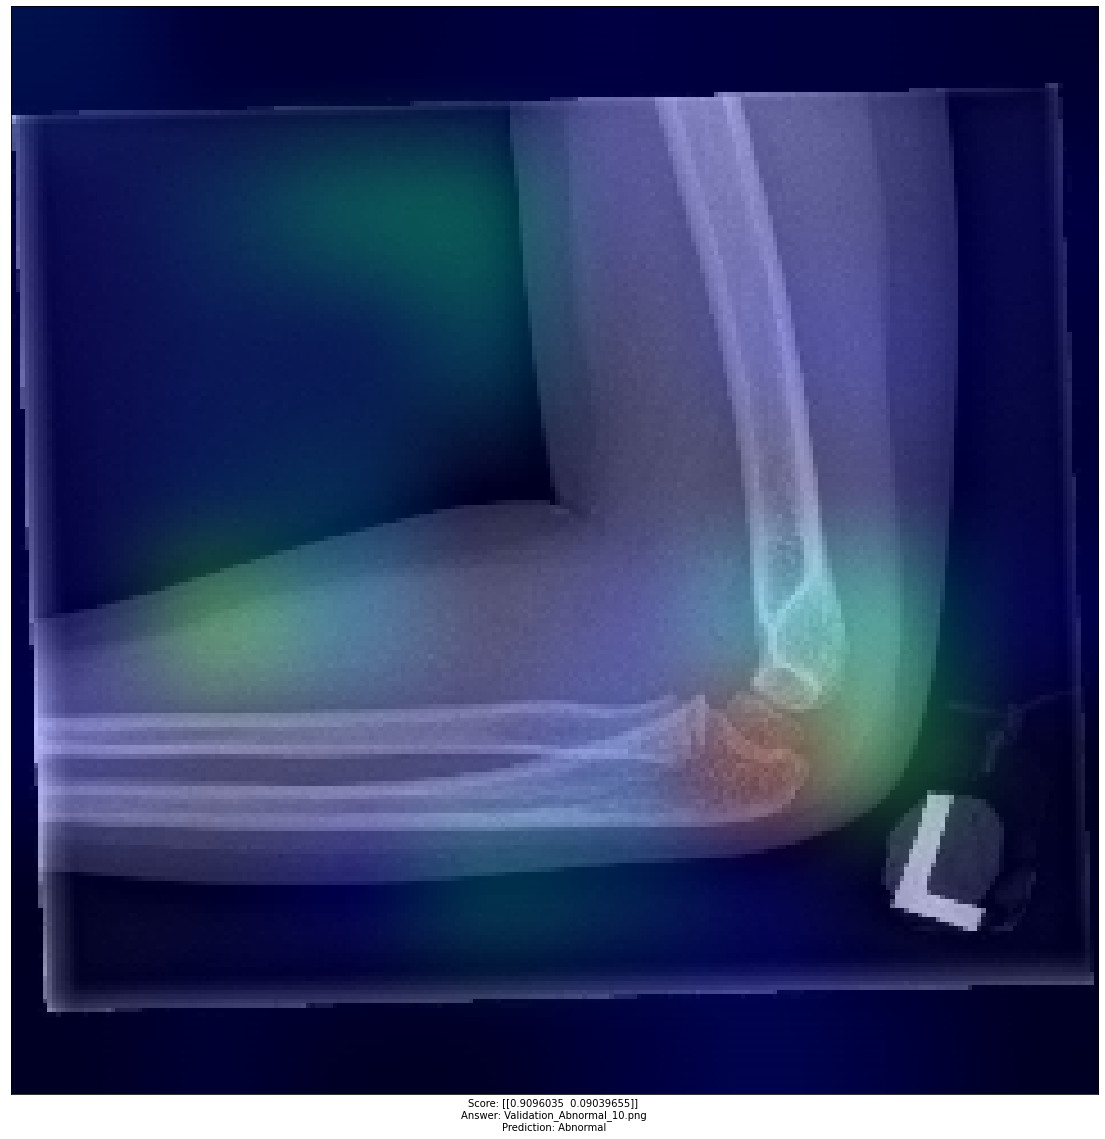

In [19]:
def overlay_heatmap(sample_image_path, heatmap):
    # We load the original image
    img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(data['image_dims'],data['image_dims']))
    img = tf.keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    model_input = produce_model_inputs(sample_image_path, data)
    prediction, result = predict_image(model_input,model)

    plt.figure(figsize=[20,20])
    plt.imshow(superimposed_img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'Score: {prediction} \nAnswer: {os.path.basename(sample_image_path)}\nPrediction: {result}');
    

overlay_heatmap(sample_image_path, heatmap)
plt.savefig('/workspaces/ecdl/heatmaps/sample.jpg')

# Choose image here

In [14]:
# sample_image_path = 'elbow_data/SABINE 114 size test set/001_Normal011.jpg'
# sample_image_path = 'elbow_data/SABINE 114 size test set/002_Abnormal001.jpg'
# sample_image_path = 'elbow_data/SABINE 114 size test set/003_Abnormal009.jpg'

# sample_image_path = 'sample_images/elbow_broken.jpeg'
# sample_image_path = 'sample_images/elbow_fracture_1.jpg'

sample_image_path = '/workspaces/ecdl/elbow_data/Clean_Data/SecondTestSet/Abnormal/Validation_Abnormal_10.png'

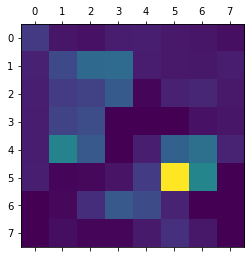

In [15]:

img_array = produce_model_inputs(sample_image_path, data)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    activation_layer='top_activation',
)

# Display heatmap
plt.matshow(heatmap)

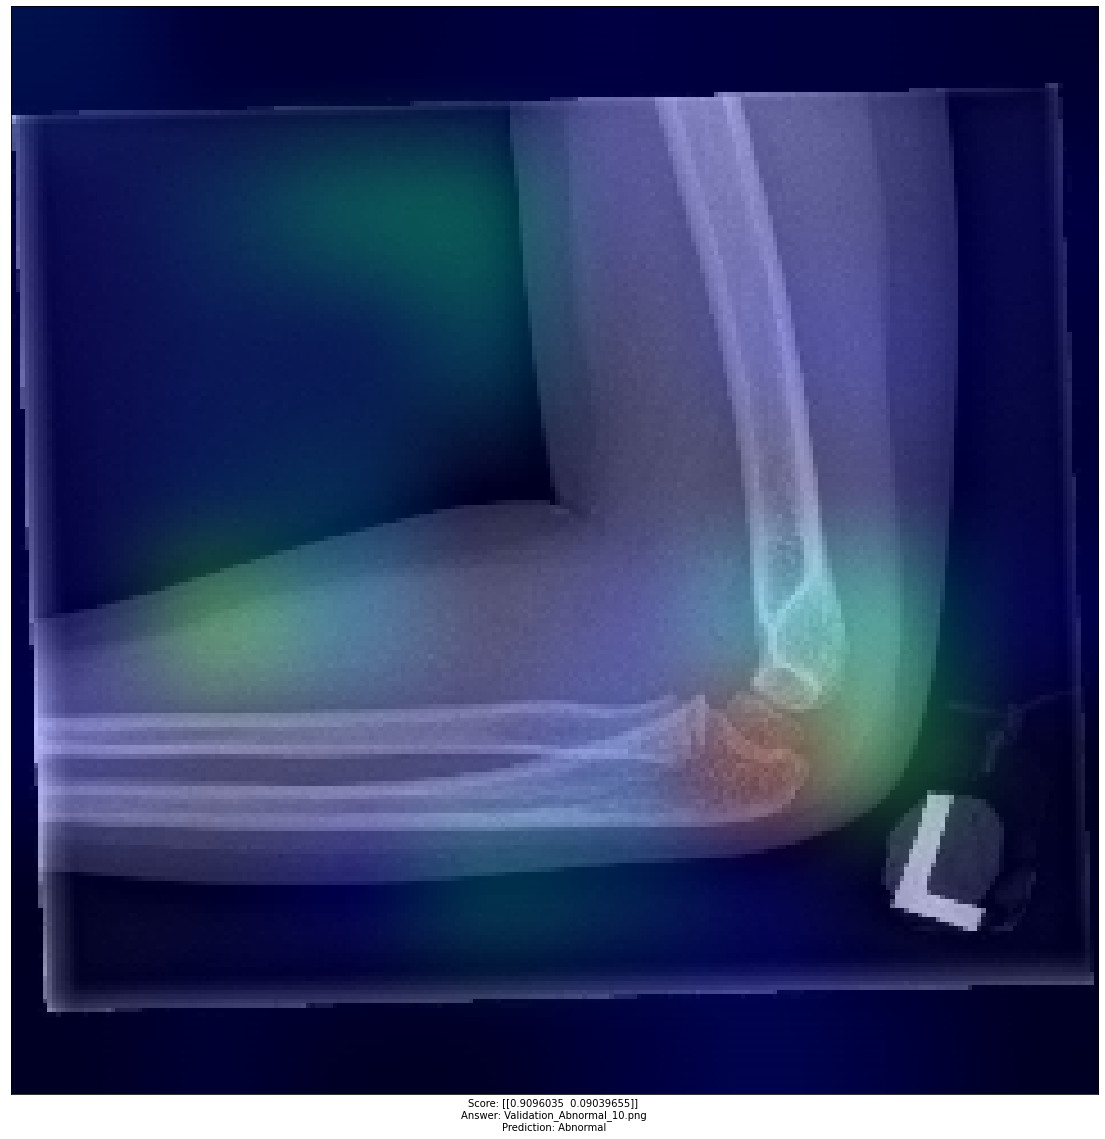

In [16]:
overlay_heatmap(sample_image_path, heatmap)